# <font color='#36648B'>**Machine Learning Assignment**</font>

## <font color='#4F94CD'>**PART 1:** Model Definition, Evaluation and Fairness Processing Code</font>



### <font color='#00688B'>**IMPORT:**</font> Packages and Datasets

In [ ]:
# Install AI Fair 360 toolbox
!pip install 'aif360[all]'

     |████████████████████████████████| 175 kB 13.1 MB/s 
     |████████████████████████████████| 1.3 MB 38.7 MB/s 
     |████████████████████████████████| 2.8 MB 44.9 MB/s 
     |████████████████████████████████| 2.6 MB 40.4 MB/s 
     |████████████████████████████████| 275 kB 41.2 MB/s 
     |████████████████████████████████| 21.2 MB 1.7 MB/s 
     |████████████████████████████████| 3.3 MB 37.8 MB/s 
     |████████████████████████████████| 34.5 MB 1.3 MB/s 
     |████████████████████████████████| 462 kB 41.6 MB/s 
     |████████████████████████████████| 564 kB 39.9 MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=39d055f39dcd5168f80f3ec77c8efb6f03b42c3c5922c634e495b9fcd7afe502
  Stored in directory: /root/.cache/pip/wheels/05/9f/ee/541a74be4cf5dad17430e64d3276370ea7b6a834a76cb4215a
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f4f184a35d87b44ba309ddefacd069098069f460bfea86ead434

In [ ]:
# Import NumPy and Pandas
import pandas as pd
import numpy as np
np.random.seed(16)

# AIF360 Fairness package
from aif360.datasets import AdultDataset, GermanDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

# SKLearn Packages for data scaaling and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import *

# PyTorch packages to build LogisticRegression 1 layer NN model
import torch
import torch.nn as nn
from tqdm import tqdm
torch.manual_seed(16)

# Packages to plot the results of hyperparameter testing
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2022-05-12 18:04:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  3.19MB/s    in 1.2s    

2022-05-12 18:04:02 (3.19 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-05-12 18:04:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names’

adult.names         100%[===================>]   5.11K  --.-KB/s    in 0s      

2022-

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

--2022-05-12 18:04:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data’

german.data         100%[===================>]  77.92K   259KB/s    in 0.3s    

2022-05-12 18:04:06 (259 KB/s) - ‘german.data’ saved [79793/79793]

--2022-05-12 18:04:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/x-httpd-php]
Saving to: ‘german.doc’

german.doc          100%[===================>]   4.57K  --.-KB/s    in 0s  

### <font color='#009ACD'>**LOAD:**</font> Datasets and Hyperparameters to Test

In [ ]:
# Load Adult dataset and define the sensitive feature
adult_data_sex = load_preproc_data_adult(['sex'])
adult_data_race = load_preproc_data_adult(['race'])

# Load German dataset, define the sensitive feature and adjust binary labels to 0 and 1
german_data_sex = load_preproc_data_german(['sex'])
german_data_sex.labels = np.float64(np.where(german_data_sex.labels.copy() > 1, 0, 1))
german_data_sex.unfavorable_label = 0.0

german_data_age = load_preproc_data_german(['age'])
german_data_age.labels = np.float64(np.where(german_data_age.labels.copy() > 1, 0, 1))
german_data_age.unfavorable_label = 0.0

In [ ]:
# Shuffle and split data into training (70%) and test (30%) sets
adult_trn_s, adult_tst_s = adult_data_sex.split([0.7], shuffle=True, seed=16)
adult_trn_r, adult_tst_r = adult_data_race.split([0.7], shuffle=True, seed=16)
german_trn_s, german_tst_s = german_data_sex.split([0.7], shuffle=True, seed=16)
german_trn_a, german_tst_a = german_data_age.split([0.7], shuffle=True, seed=16)

In [ ]:
# Define list of hyperparameter for model testing
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
reg_strength = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
epochs = 100000

### <font color='#00B2EE'>**CLASS:**</font> LogisticRegression

In [ ]:
class LogisticRegression(nn.Module):

  def __init__(self, input_features):
    """
    Constructor for LogisticRegression Class 

    Parameters:
      input_features: Number of input features for the model
    """

    super(LogisticRegression, self).__init__()
    self.input_features = input_features
    self.fc_layer1 = nn.Linear(input_features,1)                                


  def forward(self, x):
    """
    Forward pass, one fully connected linear layer with sigmoid activation

    Parameters:
      x: input data with binary labels (0 or 1) as tensor

    Returns:
      y_predicted: LogisitcRegression predictions  
    """
    
    y_predicted = torch.sigmoid(self.fc_layer1(x))
    return y_predicted

### <font color='#00B2EE'>**CLASS:**</font> FairnessProcessing

In [ ]:
class FairnessProcessing ():
  
  def __init__(self, sensitive_feature): 
    """
    Constructor for FairnessProcessing class

    Parameters: 
      sensitive_feature: sensitive feature used to calculate fairness metrics
    """

    self.sensitive_feature = sensitive_feature
    self.unpriv = [{self.sensitive_feature: 0}]
    self.priv = [{self.sensitive_feature: 1}]


  def dataset_analysis(self, dataset):
    """
    Analyse AIF360 binary label dataset based on sensitive feature defined when 
    instantiating FairnessProcessing class

    Consistency = Individual fairness metric, 5 nearest neighbours for KNN computation
    Mean Difference = Statistical parity difference

    Parameters: 
      dataset: binary label AIF360 dataset 

    Returns:
      Print consistency score 
      Print mean difference
    """

    dataset_metrics = BinaryLabelDatasetMetric(dataset, 
                                               unprivileged_groups=self.unpriv, 
                                               privileged_groups=self.priv)
    print('\033[1mConsistency:\033[0m', dataset_metrics.consistency())
    print('\033[1mMean Difference:\033[0m', dataset_metrics.mean_difference())


  def accuracy_score(self, y_pred, y_test):                                     
    """
    Returns accuracy score for trained model, used for model evaluation

    Parameters:
      y_pred: label predictions from logistic regression model as array
      y_test: groundtruth labels from dataset as array
    """

    return np.sum(y_pred==y_test.detach().numpy())/len(y_test)


  def equal_opp(self, data_test, test_predictions):                             
    """
    Equality of opportunity fairness metric calculated with AIF360 
    ClassificationMetrics. A score of 0 indicates no bias. A negative score 
    indicates bias towards the privileged group and a positive score bias 
    towards the unprivileged group

    Parameters:
      data_test: test subset of AIF360 binary label dataset as array 
      test_predictions: test subset of AIF360 binary label dataset with 
                        groundtruth labels replaced with model label predictions
    
    Returns:
      equal_opp: Equality of opportunity calcualtion (float)
    """

    metric = ClassificationMetric(data_test, test_predictions, 
                                  unprivileged_groups=self.unpriv, 
                                  privileged_groups=self.priv)
    equal_opp = metric.equal_opportunity_difference()
    return equal_opp


  def reweigh (self, data_train):
    """
    Pre-processing method to reweigh the data based on each combination of 
    sensitive group and label. This technique should be applied to the training 
    data before passed to the classification mdoel

    Paramters: 
      data_train: training subset of original dataset as array

    Returns: 
      data_reweighed: AIF360 binary label dataset with adjusted instance weights
    """

    rwt = Reweighing(unprivileged_groups = self.unpriv,                         
                    privileged_groups = self.priv)                              
    rwt.fit(data_train)
    data_reweighed = rwt.transform(data_train)
    return data_reweighed


  def suppress_sens(self, data_train, data_test, 
                    suppress_sens=True, only_sens=True ):
    """
    Pre-processing method to remove the sensitive feature(s) from the AIF360 
    binary label dataset before training the classifier

    Parameters:
      data_train: training subset of original dataset as array
      data_test: test subset of original dataset as array
      suppress_sens: default true initiates the function
      only_sens: default True removes the first sensitive feature, False removes 
                 both sensitive features in the dataset

    Returns: 
      train: copy of training subset of original dataset with sensitive 
             feature(s) removed
      test: copy of test subset of original dataset with sensitive feature(s) 
            removed
    """
    train = data_train.copy()
    test = data_test.copy()
    if suppress_sens == True:
      if only_sens == True:
        train.features = train.features[:, 1:]
        test.features = test.features[:, 1:]                          
      else:
        train.features = train.features[:, 2:]
        test.features = test.features[:, 2:]
    
    return train, test


  def tradeoff_metric (self, accuracy, fairness):
    """
    Custom trade-off metric for accuracy and fairness. The square of the 
    absolute fairness score is subtracted from the accuracy score in order to 
    penalise models for high levels of bias. High trade-off values indicate 
    models that have a favorable balance between accuracy and fairness.

    Parameters:
      accuracy: accuracy score as calculated by accuracy_score
      fairness: fairness score as calculated by equal_opp

    Returns: 
      tradeoff_metric: calculated trade-off value 
    """
    tradeoff_metric = accuracy - (abs(fairness)**2)
    return tradeoff_metric

### <font color='#00B2EE'>**CLASS:**</font> ProcessData

In [ ]:
class ProcessData():

  def __init__(self):
    """
    Constructor for ProcessData class 
    """

    self.sc = StandardScaler()


  def scale_data (self, data_train, data_test):
    """
    SKLearn standard scaler applied to fit and transform training data and 
    ransform test data so that the mean is equal to zero with a standard 
    deviation of 1. Train and test label arrays converted to contiguous 
    flattened arrays

    Parameters:
      data_train: training subset of original dataset as array
      data_test: test subset of original dataset as array

    Returns:
      x_train: scaled training feature data as array
      x_test: scaled test feature data as array
      y_train: flattened array of training labels
      y_test: flattened array of test labels
    """

    x_train = self.sc.fit_transform(data_train.features)                        
    y_train = data_train.labels.ravel()                                         
    x_test = self.sc.transform(data_test.features)                              
    y_test = data_test.labels.ravel()
    return x_train, x_test, y_train, y_test


  def cnvt_tensor (self, x_train, x_test, y_train, y_test):
    """
    Convert numpy arrays to tesnors in order to pass data to LogisticRegression 
    model

    Parameters:
      x_train: scaled training feature data as array
      x_test: scaled test feature data as array
      y_train: flattened array of training labels
      y_test: flattened array of test labels

    Returns:
      x_train: scaled training feature data as tensor
      x_test: scaled test feature data as tensor
      y_train: training labels as tensor
      y_test: test labels as tensor

    """ 
                                                                                
    x_train, x_test = torch.Tensor(x_train),torch.Tensor(x_test)
    y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test) 
    return x_train, x_test, y_train, y_test

### <font color='#00B2EE'>**CLASS:**</font> EvaluateModel

In [ ]:
class EvaluateModel():

  def __init__ (self, sensitive_feature):
    """
    Constructor for EvaluateModel class

    Parameters: 
      sensitive_feature: sensitive feature used to calculate fairness metrics 
    """

    self.sensitive_feature = sensitive_feature
    self.unpriv = [{self.sensitive_feature: 0}]
    self.priv = [{self.sensitive_feature: 1}]
    self.PD = ProcessData()
    self.FP = FairnessProcessing(self.sensitive_feature)

  def fit (self, data_train, data_test, lr, reg, epochs, reweight=False, 
           suppress_sens=False, only_sens=True):
    """
    Function to train the LogisticRegression model on training data. PyTorch 
    Binary Cross Entropy Loss and Stochastic Gradient Descent optimiser are used 
    to calculate the loss and udpate the model weights at each epoch. Stopping 
    criteria implemented to break training once the loss converges to 1e-3 
    (based on SKLearn's SGDClassifier early_stopping criteria)

    Parameters:
      data_train: training subset of original dataset as array
      data_test: test subset of original dataset as array
      lr: learning rate hyperparameter
      reg: L2 regularisation strength 
      epochs: number of training epochs
      reweight: if True, reweigh the training data, if false do not pre-process 
                the training data
      suppress_sens: if True, remove sensitive feature(s) from the dataset. If 
                     False, do not remove sensitive features from the dataset
      only_sens: if True, only remove the first sensitive feature from the 
                 dataset. If False, remove both sensitive features

    Returns: 
      fit_data: dictionary of model training data, keys = accuracy, fair, 
                tradeoff, epoch 
      test_predictions: AIF360 test subset of original binary label dataset with 
                        labels replaced with model predictions
    """

    fit_data = {}

    # SUPPRESS ONE OR BOTH SENSITIVE FEATURES IF TRUE 
    if suppress_sens == True:
      data_train, data_test = self.FP.suppress_sens(data_train, 
                                                    data_test, 
                                                    suppress_sens=suppress_sens, 
                                                    only_sens=only_sens)
      n_samples, n_features = data_train.features.shape 
    else:
      n_samples, n_features = data_train.features.shape                        

    # DEFINE AND SCALE THE TEST AND TRAIN DATA 
    x_train, x_test, y_train, y_test = self.PD.scale_data(data_train, 
                                                          data_test) 
               
    x_train, x_test, y_train, y_test = self.PD.cnvt_tensor(x_train, 
                                                           x_test, 
                                                           y_train, 
                                                           y_test)


    # DEFINE SGD OPTIMISER WITH L2 REGULARISATION (weight_decay)
    model = LogisticRegression(n_features)
    optimiser = torch.optim.SGD(model.parameters(),
                                lr=lr, 
                                weight_decay=reg)     

    # ADJUST BCELOSS FUNCTION BASED ON REWEIGHTING TRUE OR FALSE
    if reweight == True:                                                        
      rwt = self.FP.reweigh(data_train)
      weights = torch.tensor(rwt.instance_weights.copy())
      loss_function_rwt = nn.BCELoss(weight=weights)
      loss_function = nn.BCELoss()
    else:
      loss_function = nn.BCELoss()
    
    # TRAIN THE MODEL ON SET HYPERPARAMETERS
    iter = 0
    best_loss = 10
    for epoch in tqdm(range(epochs)):
      optimiser.zero_grad()
      y_pred = model(x_train)
      if reweight == True:
        loss = loss_function_rwt(torch.squeeze(y_pred), y_train)
      else:
        loss = loss_function(torch.squeeze(y_pred), y_train)
      loss.backward()
      optimiser.step()
      
      # STOPPING CRITERIA WHEN LOSS CONVERGES AT 1e-3
      iter+=1
      if iter%100 == 0:
        y_pred_validate = model(x_test)
        loss_validate = loss_function(torch.squeeze(y_pred_validate), y_test)
        if loss_validate > (best_loss - 1e-3):
          break
        else:
          best_loss = loss_validate
        
    with torch.no_grad():
      # CALCULATE THE ACCURACY OF THE TEST PREDICTIONS VS. TEST LABELS
      y_pred_test = torch.squeeze(model(x_test))                             
      predicted_labels = y_pred_test.round().detach().numpy()
      fit_data['accuracy'] = self.FP.accuracy_score(predicted_labels, y_test)
      
      # CALCULATE THE FAIRNESS OF MODEL USING TEST DATASET AND PREDICTED LABELS
      test_predictions = data_test.copy()                                      
      test_predictions.labels = predicted_labels
      fit_data['fair'] = self.FP.equal_opp(data_test, test_predictions)

      # CALCULATE TRADE-OFF METRIC FOR THE MODEL
      fit_data['tradeoff'] = self.FP.tradeoff_metric(fit_data['accuracy'], 
                                                     fit_data['fair'])

      fit_data['epoch'] = iter

    return fit_data, test_predictions                                         
  

  def cross_validation (self, data_train, lr, reg, epochs, reweight=False,
                        k=5, suppress_sens=False, only_sens=True):
    """
    SKLearn StratifiedKFold used to split the data into k-folds with the same 
    distribution of labels. Cross validation implemented across all folds and 
    the mean accuracy, fairness, trade-off and epochs are calculated and stored

    Parameters:
      data_train: training subset of original dataset as array
      lr: learning rate hyperparameter
      reg: L2 regularisation strength 
      epochs: number of training epochs
      reweight: if True, reweigh the training data, if false do not pre-process 
                the training data
      k: number of folds to split the training data into, default is 5
      suppress_sens: if True, remove sensitive feature(s) from the dataset. If 
                     False, do not remove sensitive features from the dataset
      only_sens: if True, only remove the first sensitive feature from the 
                 dataset. If False, remove both sensitive features

    Returns: 
      mean_metrics: dictionary of mean accuracy, fairness, trade-off and epoch 
                    values as well as hyperparameters. Keys = epoch, lr, reg, 
                    acc, fair, tradeoff
    """

    # NUMBER OF K-FOLDS
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=16)                              
    data = data_train.copy()                                                    
    
    # LISTS TO STORE ACCURACY, FAIRNESS, TRADE-OFF AND EPOCH VALUES
    fairness_scores = []
    accuracy_scores = []                                                        
    tradeoff_score = []
    epoch_train = []
    
    for train_index, test_index in kf.split(data.features, data.labels):        # Iterate over folds, fit the LR model (regular or reweighted as defined in args)
      train_fold = data.subset(train_index)                                     # Define the train and test datasets based on the StratifiedKFold generated indices
      test_fold = data.subset(test_index)                                       # Method .subset used to created datasets for each fold that retain AIF360 BinaryDataSet properties
      model = EvaluateModel(self.sensitive_feature)

      # SUPPRESS SENSITIVE GROUP IF suppress_sens IS TRUE
      if suppress_sens == True:
        train_fold, test_fold = self.FP.suppress_sens(train_fold, 
                                                      test_fold,
                                                      suppress_sens=suppress_sens, 
                                                      only_sens=only_sens)
        fit_data, test_pred = model.fit(train_fold, 
                                        test_fold, 
                                        lr, 
                                        reg, 
                                        epochs)
      
      # REWEIGH THE DATA IF reweigh IS TRUE      
      elif reweight == True:
        fit_data, test_pred = model.fit(train_fold, 
                                        test_fold,
                                        lr, 
                                        reg, 
                                        epochs,
                                        reweight=reweight)
      
      else:
        fit_data, test_pred = model.fit(train_fold, 
                                        test_fold, 
                                        lr, 
                                        reg, 
                                        epochs)
        
      accuracy_scores.append(fit_data['accuracy'])                              
      fairness_scores.append(fit_data['fair'])
      epoch_train.append(fit_data['epoch'])
      tradeoff_score.append(fit_data['tradeoff'])
    
    mean_metrics = {}
    mean_metrics['accuracy'] = np.mean(accuracy_scores)
    mean_metrics['fair'] = np.mean(fairness_scores)
    mean_metrics['epoch'] = np.mean(epoch_train)
    mean_metrics['tradeoff'] = np.mean(tradeoff_score)

    return mean_metrics                                                     


  def test_hyperparam (self, data_train, learning_rates, reg_strength, epochs, 
                        reweight=False, suppress_sens=False, only_sens=True):
    """
    Cross-validation of hyperparameter testing for each combination of learning 
    rate and regularisation strength.  

    Parameters:
      data_train: training subset of original dataset as array
      learning_rates: list of learning rates to test
      reg_strength: list of L2 regularisation strengths to test 
      epochs: number of training epochs
      reweight: if True, reweigh the training data, if false do not pre-process 
                the training data
      suppress_sens: if True, remove sensitive feature(s) from the dataset. If 
                     False, do not remove sensitive features from the dataset
      only_sens: if True, only remove the first sensitive feature from the 
                 dataset. If False, remove both sensitive features

    Returns: 
      hyperparam_data: dictionary of mean accuracy, fairness, trade-off and epoch 
                       values for each hyperparameter combination. Keys = epoch, 
                       lr, reg, acc, fair, tradeoff
    """

    hyperparam_data = {'epoch':[], 'lr':[], 'reg':[], 
                       'acc':[], 'fair':[], 'tradeoff':[]}
    
    for lr in learning_rates:
      for reg in reg_strength:
        model = EvaluateModel(self.sensitive_feature)
        mean_metrics = model.cross_validation(data_train,
                                              lr,
                                              reg, 
                                              epochs,
                                              reweight=reweight,
                                              suppress_sens=suppress_sens,
                                              only_sens=only_sens)
        
        hyperparam_data['epoch'].append(mean_metrics['epoch'])
        hyperparam_data['lr'].append(lr)
        hyperparam_data['reg'].append(reg)
        hyperparam_data['acc'].append(mean_metrics['accuracy'])
        hyperparam_data['fair'].append(mean_metrics['fair'])
        hyperparam_data['tradeoff'].append(mean_metrics['tradeoff'])
    
    return hyperparam_data

### <font color='#00B2EE'>**CLASS:**</font> PlotGraphs

In [ ]:
class PlotGraphs():
  
  def __init__ (self, sensitive_feature):
    """
    Constructor for PlotGraphs class

    Parameters: 
      sensitive_feature: sensitive feature used to define fairness metrics 
    """
    self.sensitive_feature = sensitive_feature
    self.FP = FairnessProcessing(self.sensitive_feature)
  

  def plot_heatmap(self, hp, dataset_name):
    """
    Plots two seaborn heatmaps with X axis as learning rate and y axis as 
    regularisation strength
    (1) Model accuracy: ColourMap = green is more accurate and red less accurate 
    (2) Model fairness: ColourMap = white is most fair, darker blue indicates 
                        more bias either negative or positive

    Parameters:
      hp: dictionary of hyperparameter testing values generated by 
          EvaluateModel.test_hyperparam
      dataset_name: dataset name as string for graph title
    
    Returns: 
      plot: seaborn heatmap of model accuracy based on hyperparameters
      plot: seaborn heatmap of model fairness based on hyperparameters
    """

    hm_data = pd.DataFrame(data={'x':hp['lr'], 'y':hp['reg'], 
                                 'acc':hp['acc'],                               
                                 'fairness':hp['fair']})                        
    hm_data_acc = hm_data.pivot(index='y', columns='x', values='acc')
    hm_data_fair = hm_data.pivot(index='y', columns='x', values='fairness')

    cmap_acc = cmap = sns.diverging_palette(10, 150, s=95, l=65, as_cmap=True)  
    cmap_fair = sns.diverging_palette(240, 240, s=95, l=65, center='light', 
                                      as_cmap=True)

    plt.figure(figsize=(20,8))
    sns.set(font_scale=1.2)
    # (1) MODEL ACCURACY HEATMAP
    plt.subplot(121)                                                           
    ax1 = sns.heatmap(hm_data_acc, annot=True, cmap=cmap_acc)
    ax1.set_title(f'\nAccuracy\n{dataset_name}')
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Regularisation')
    # (2) MODEL FAIRNESS HEATMAP
    plt.subplot(122)                                                            
    ax2 = sns.heatmap(hm_data_fair, center=0, annot=True, cmap=cmap_fair)
    ax2.set_title(f'\nFairness\n{dataset_name}')
    ax2.set_xlabel('Learning Rate')
    ax2.set_ylabel('Regularisation')
    plt.show()


  def plot_cfmatrix (self, fit_data, test_predictions, data_test, 
                     favourable_label, unfavourable_label, 
                     title, dataset_name):
    """
    Plot seaborn heatmap from SKLearn confusion matrix. Print model training 
    epochs, accuracy and fairness

    Parameters:
      fit_data: dictionary of model training data, keys = accuracy, fair, 
                tradeoff, epoch 
      test_predictions: AIF360 test subset of original binary label dataset with 
                        labels replaced with model predictions
      data_test: test subset of original dataset as array
      favourable_label: favourable label as a string
      unfavourable_label: unfavourable label as a string
      title: metric used to define model as a string
      dataset_name: dataset name as string for graph title

    Returns: 
      plot: confusion matrix heatmap
      print: training epochs
      print: model accuracy
      print: model fairness
    """
    
    predictions = test_predictions.labels
    groundtruth = data_test.labels
    classes = (unfavourable_label, favourable_label)

    cfmatrix = confusion_matrix(groundtruth, predictions)
    cm_data = pd.DataFrame(cfmatrix/np.sum(cfmatrix), 
                           index = [i for i in classes],
                           columns = [i for i in classes])

    names = ['True Negative','False Positive','False Negative','True Positive']
    counts = ["{:,}".format(value) for value in cfmatrix.flatten()]
    percent = ["{0:.2%}".format(value) for value in cfmatrix.flatten()/np.sum(cfmatrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percent)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (12,7))
    plt.title(f'\nConfusion Matrix for {title} Model\n{dataset_name}\n')
    sns.set(font_scale=1.4)
    sns.heatmap(cm_data, annot=labels, fmt='', cmap='binary')
    plt.show()
    print('\n\033[1mEpochs:\033[0m', fit_data['epoch'])
    print('\033[1mAccuracy:\033[0m', "{0:.2%}".format(fit_data['accuracy']))
    print('\033[1mFairness:\033[0m',"{0:.4}".format(fit_data['fair']))


  def tradeoff_heatmap(self, model_data, fair_data, dataset_name):
    """
    Plots two seaborn heatmaps with X axis as learning rate and y axis as 
    regularisation strength with trade-off metric as the values
    (1) Standard Model: ColourMap = turquoise is more accurate and yellow less 
                        accurate 
    (2) Fair Model: ColourMap = turquoise is more accurate and yellow less 
                    accurate 

    Parameters:
      model_data: dictionary of hyperparameter testing values generated by 
                  EvaluateModel.test_hyperparam for standard model
      fair_data: dictionary of hyperparameter testing values generated by 
                  EvaluateModel.test_hyperparam for fair model
      dataset_name: name of dataset as string

    Returns:
      plot: seaborn heatmap of standard model trade-off metric based on 
            hyperparameters
      plot: seaborn heatmap of fair model trade-off metric based on 
            hyperparameters
    """
    hm_data = pd.DataFrame(data={'x':model_data['lr'], 
                             'y':model_data['reg'], 
                             'acc':model_data['acc'], 
                             'fairness':model_data['fair'],
                             'new_met_reg': model_data['tradeoff'],
                             'new_met_fair': fair_data['tradeoff']})  

    hm_data_regular = hm_data.pivot(index='y', columns='x', values='new_met_reg')
    hm_data_fair = hm_data.pivot(index='y', columns='x', values='new_met_fair')
    cmap = cmap = sns.diverging_palette(45, 195, s=95, l=65, as_cmap=True)

    plt.figure(figsize=(20,8))
    sns.set(font_scale=1.2)
    # STANDARD MODEL TRADE-OFF METRIC
    plt.subplot(121)                                                            
    ax1 = sns.heatmap(hm_data_regular, annot=True, cmap=cmap)
    ax1.set_title(f'\nTrade-off Metric (Regular Model)\n{dataset_name}')
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Regularisation')
    # FAIR MODEL TRADE-OFF METRIC
    plt.subplot(122)                                                            
    ax2 = sns.heatmap(hm_data_fair, annot=True, cmap=cmap)
    ax2.set_title(f'\nTrade-off Metric (Fair Model)\n{dataset_name}')
    ax2.set_xlabel('Learning Rate')
    ax2.set_ylabel('Regularisation')
    plt.show()

## <font color='#6959CD'>**PART 2:** Initial Exploratory Data Analysis of Bias in Datasets</font>

In [ ]:
# ADULT DATASET SEX
print('\033[1mAdult Dataset - Sex\033[0m')
FP_as = FairnessProcessing('sex')
FP_as.dataset_analysis(adult_data_sex)

Adult Dataset - Sex
Consistency: [0.71931944]
Mean Difference: -0.19451574596420296


In [ ]:
# ADULT DATASET RACE
print('\033[1mAdult Dataset - Race\033[0m')
FP_ar = FairnessProcessing('race')
FP_ar.dataset_analysis(adult_data_race)

Adult Dataset - Race
Consistency: [0.71931944]
Mean Difference: -0.10144450514172723


In [ ]:
# GERMAN DATASET SEX
print('\033[1mGerman Dataset - Sex\033[0m')
FP_gs = FairnessProcessing('sex')
FP_gs.dataset_analysis(german_data_sex)

German Dataset - Sex
Consistency: [0.6614]
Mean Difference: -0.07480130902290782


In [ ]:
# GERMAN DATASET AGE
print('\033[1mGerman Dataset - Age\033[0m')
FP_ga = FairnessProcessing('age')
FP_ga.dataset_analysis(german_data_age)

German Dataset - Age
Consistency: [0.6614]
Mean Difference: -0.14944769330734242


## <font color='#008B45'>**PART 3:** Task 1, 2 and 3 - Adult Dataset <font>

### <font color='#008000'>TASK 1: ADULT</font>

In [ ]:
# EVALUATE HYPERPARAMETERS FOR ADULT DATASET FOR STANDARD MODEL USING TRAINING DATA

ma1 = EvaluateModel('sex')
ma1_data = ma1.test_hyperparam(adult_trn_s,
                               learning_rates,                                  
                               reg_strength,                                    
                               epochs=epochs)

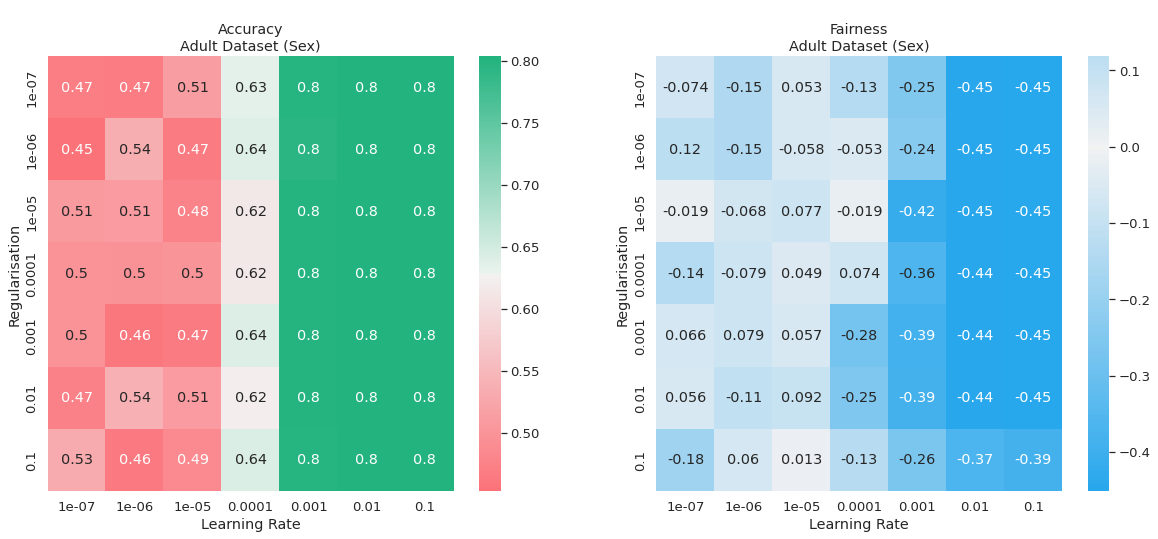

In [ ]:
# INSTANTIATE PlotGraphs CLASS FOR ADULT DATASET - SEX
# PLOT HYPERPARAMETER HEATMAPS FOR ADULT DATASET

PGA = PlotGraphs('sex')
PGA.plot_heatmap(ma1_data, 
                 'Adult Dataset (Sex)')

  0%|          | 299/100000 [00:00<03:03, 543.34it/s]


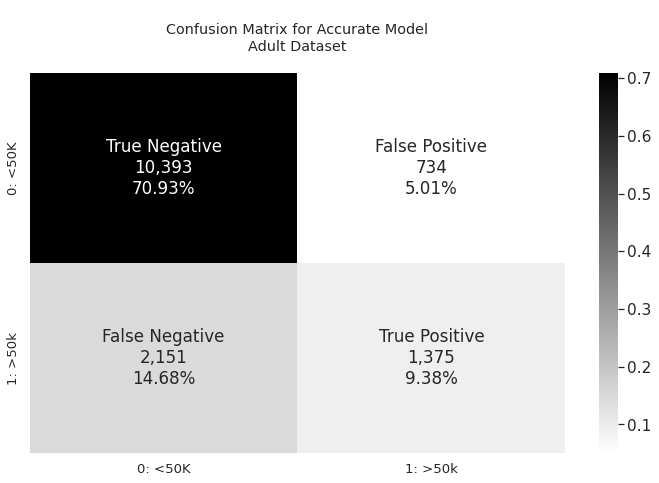


Epochs: 300
Accuracy: 80.31%
Fairness: -0.3812


In [ ]:
# MODEL (1) 
# TEST MOST ACCURATE MODEL FOR ADULT DATASET (SEX) ON TEST DATA

model1 = EvaluateModel('sex')

model1_data, test_pred1 = model1.fit(adult_trn_s, 
                                    adult_tst_s,
                                    lr=1e-1, 
                                    reg=1e-1, 
                                    epochs=epochs)

PGA.plot_cfmatrix(model1_data, 
                  test_pred1, 
                  adult_tst_s,
                  '1: >50k', 
                  '0: <50K', 
                  'Accurate', 
                  'Adult Dataset')

  0%|          | 199/100000 [00:00<03:35, 462.53it/s]


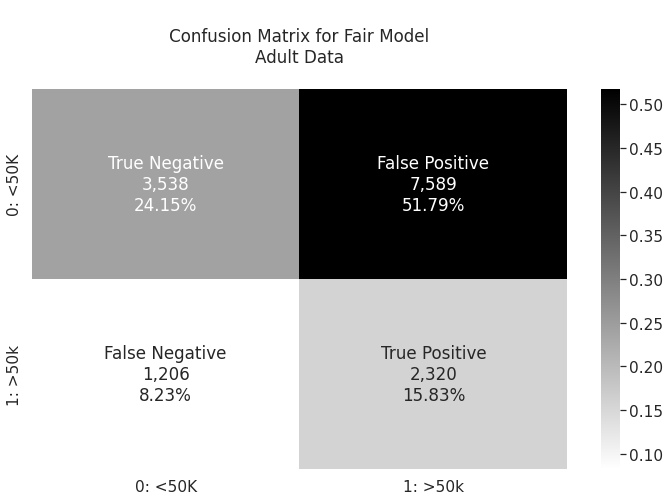


Epochs: 200
Accuracy: 39.98%
Fairness: -0.001607


In [ ]:
# MODEL (2) 
# TEST MOST FAIR MODEL FOR ADULT DATASET (SEX) ON TEST DATA

model2 = EvaluateModel('sex')

model2_data, test_pred2 = model2.fit(adult_trn_s, 
                                     adult_tst_s,
                                     lr=1e-5, 
                                     reg=1e-1, 
                                     epochs=epochs)

PGA.plot_cfmatrix(model2_data, 
                  test_pred2, 
                  adult_tst_s,
                  '1: >50k', 
                  '0: <50K',
                  'Fair', 
                  'Adult Data')

### <font color='#008000'>TASK 2: ADULT</font>

In [ ]:
# EVALUATE HYPERPARAMETERS FOR REWEIGHTED ADULT DATASET USING TRAINING DATA

ma2_rwt = EvaluateModel('sex')
ma2_data = ma2_rwt.test_hyperparam(adult_trn_s,
                                   learning_rates,
                                   reg_strength,
                                   epochs=epochs,
                                   reweight=True)

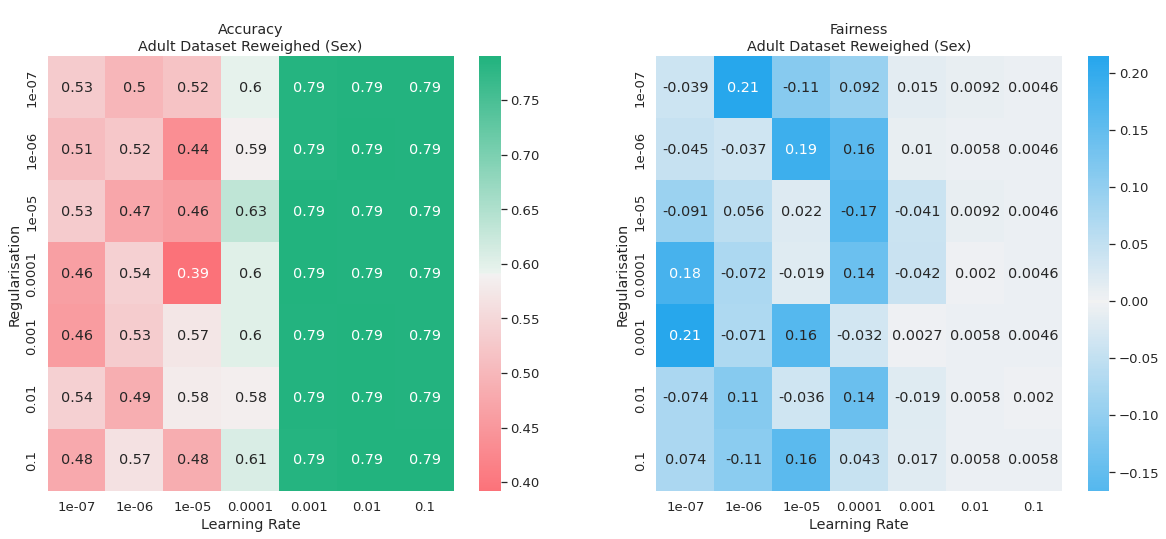

In [ ]:
PGA.plot_heatmap(ma2_data, 
                 'Adult Dataset Reweighed (Sex)')

  0%|          | 299/100000 [00:00<04:17, 387.71it/s]


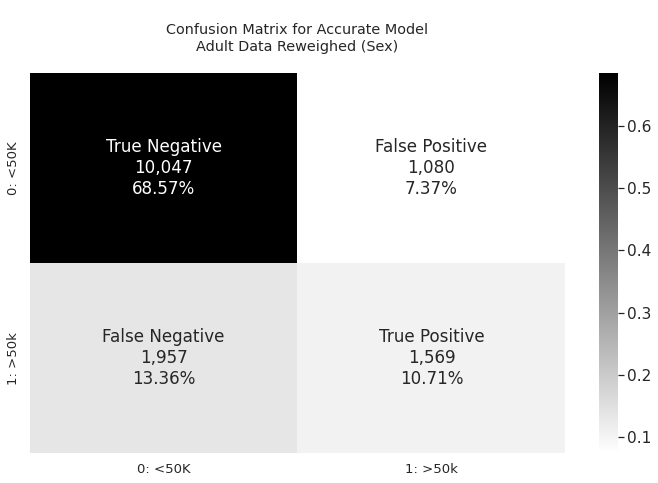


Epochs: 300
Accuracy: 79.27%
Fairness: -0.006305


In [ ]:
# MODEL (3) 
# TEST MOST ACCURATE MODEL WITH PREPROCESSED REWEIGHED TRAINING DATA ON TEST DATA

model3 = EvaluateModel('sex')

model3_data, test_pred3 = model3.fit(adult_trn_s, 
                                     adult_tst_s,
                                     lr=1e-1, 
                                     reg=1e-1, 
                                     epochs=epochs,
                                     reweight=True)

PGA.plot_cfmatrix(model3_data, 
                  test_pred3, 
                  adult_tst_s,
                  '1: >50k', 
                  '0: <50K', 
                  'Accurate', 
                  'Adult Data Reweighed (Sex)')

  0%|          | 399/100000 [00:00<03:53, 427.24it/s]


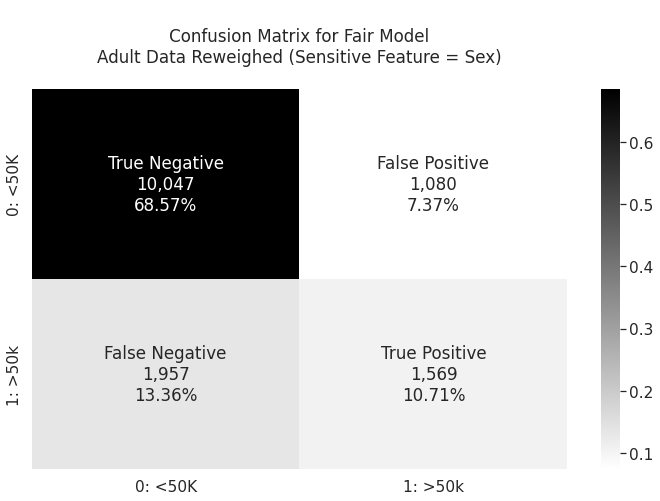


Epochs: 400
Accuracy: 79.27%
Fairness: -0.006305


In [ ]:
# MODEL (4) 
# MOST FAIR MODEL WITH PREPROCESSED REWEIGHED TRAINING DATA ON TEST DATA
 
model4 = EvaluateModel('sex')

model4_data, test_pred4 = model4.fit(adult_trn_s, 
                                     adult_tst_s,
                                     lr=1e-1, 
                                     reg=1e-2, 
                                     epochs=epochs,
                                     reweight=True)

PGA.plot_cfmatrix(model4_data, 
                  test_pred4, 
                  adult_tst_s,
                  '1: >50k', 
                  '0: <50K', 
                  'Fair', 
                  'Adult Data Reweighed (Sensitive Feature = Sex)')

### <font color='#008000'>TASK 3: ADULT</font>

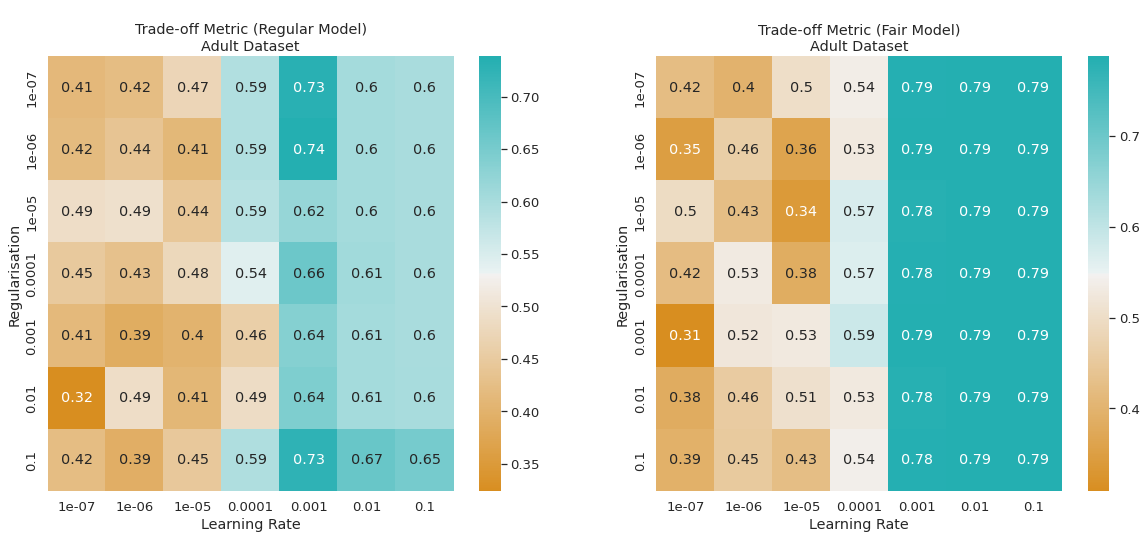

In [ ]:
# EVALUATE TRADE-OFF METRIC FOR ADULT DATASET 

PGA.tradeoff_heatmap(ma1_data, ma2_data, 'Adult Dataset')

  6%|▌         | 5799/100000 [00:09<02:40, 588.23it/s]


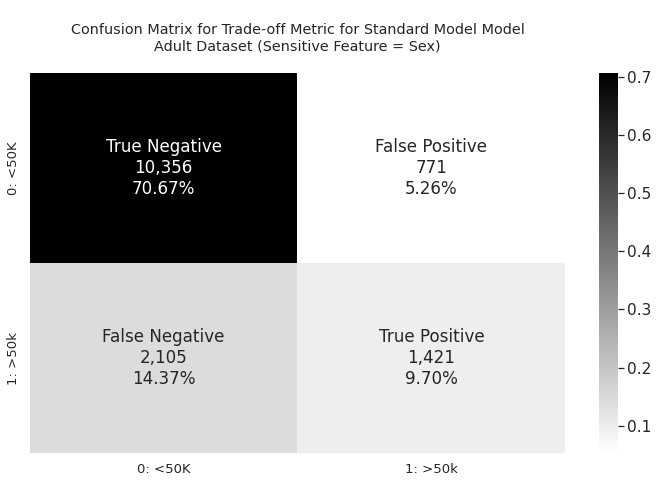


Epochs: 5800
Accuracy: 80.37%
Fairness: -0.3966


In [ ]:
# MODEL (5) 
# TEST BEST TRADE-OFF METRIC FOR STANDARD MODEL FOR ADULT DATASET (SEX) ON TEST DATA

model5 = EvaluateModel('sex')

model5_data, test_pred5 = model5.fit(adult_trn_s, 
                                     adult_tst_s,
                                     lr=1e-3, 
                                     reg=1e-6, 
                                     epochs=epochs)

PGA.plot_cfmatrix(model5_data, 
                  test_pred5, 
                  adult_tst_s,
                  '1: >50k', 
                  '0: <50K', 
                  'Trade-off Metric for Standard Model', 
                  'Adult Dataset (Sensitive Feature = Sex)')

  0%|          | 299/100000 [00:00<03:53, 426.15it/s]


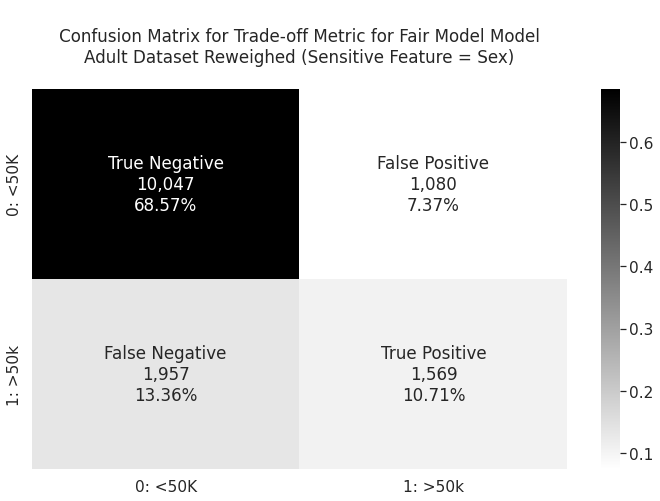


Epochs: 300
Accuracy: 79.27%
Fairness: -0.006305


In [ ]:
# MODEL (6) 
# TEST BEST TRADE-OFF METRIC FOR FAIR MODEL FOR ADULT DATASET (SEX) ON TEST DATA

model6 = EvaluateModel('sex')

model6_data, test_pred6 = model6.fit(adult_trn_s, 
                                     adult_tst_s,
                                     lr=1e-1, 
                                     reg=1e-1, 
                                     epochs=epochs,
                                     reweight=True)

PGA.plot_cfmatrix(model6_data, 
                  test_pred6, 
                  adult_tst_s,
                  '1: >50k', 
                  '0: <50K', 
                  'Trade-off Metric for Fair Model', 
                  'Adult Dataset Reweighed (Sensitive Feature = Sex)')

## <font color='#FF7F00'>**PART 4:** Task 1, 2, 3 - German Dataset</font>

### <font color='#CD661D'>TASK 1: GERMAN</font>

In [ ]:
# EVALUATE HYPERPARAMETERS FOR GERMAN DATASET FOR STANDARD MODEL USING TRAINING DATA

mg1 = EvaluateModel('age')
mg1_data = mg1.test_hyperparam(german_trn_a,
                               learning_rates,
                               reg_strength, 
                               epochs=epochs)

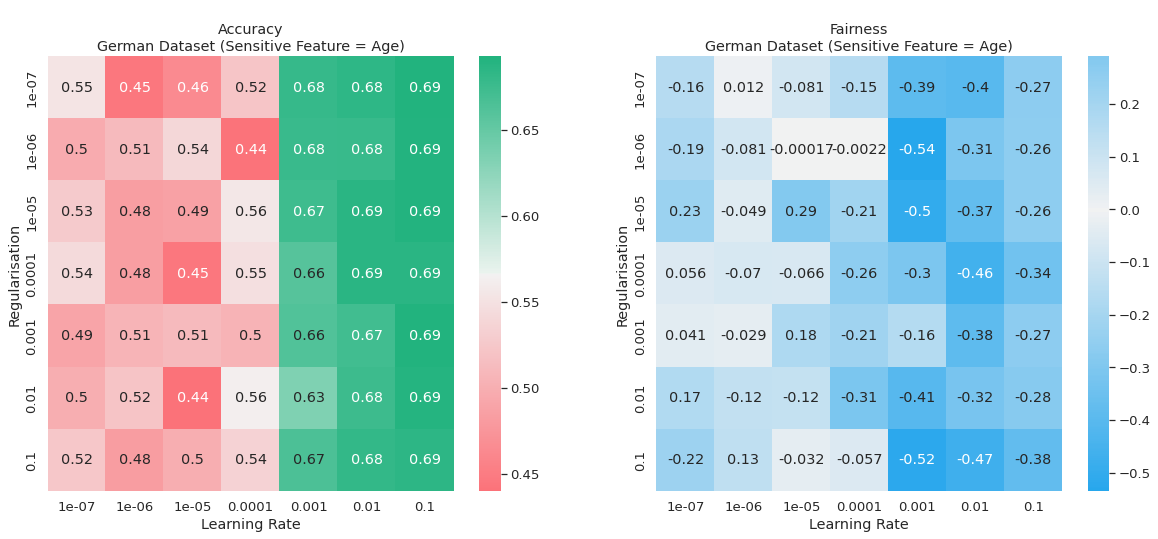

In [ ]:
# INSTANTIATE PlotGraphs CLASS FOR GERMAN DATASET - AGE
# PLOT HYPERPARAMETER HEATMAPS FOR GERMAN DATASET

PGG = PlotGraphs('age')
PGG.plot_heatmap(mg1_data,
                 'German Dataset (Sensitive Feature = Age)')

  0%|          | 299/100000 [00:00<00:45, 2201.26it/s]


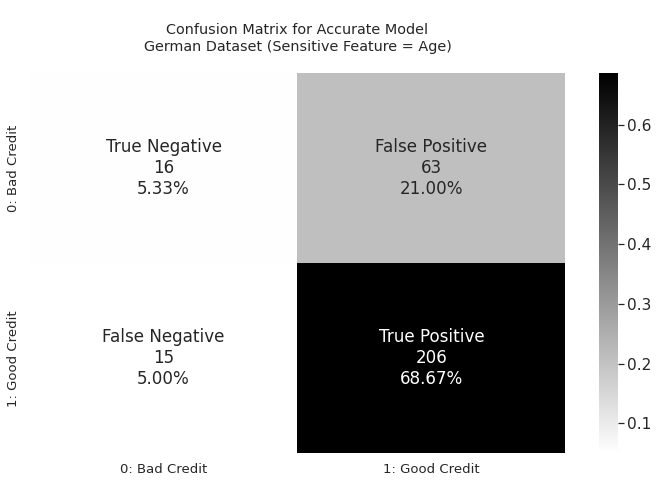


Epochs: 300
Accuracy: 74.00%
Fairness: -0.3571


In [ ]:
# MODEL (1) 
# TEST MOST ACCURATE MODEL FOR GERMAN DATASET (AGE) ON TEST DATA

model_g1 = EvaluateModel('age')

model_g1_data, test_pred_g1 = model_g1.fit(german_trn_a, 
                                           german_tst_a,
                                           lr=1e-1, 
                                           reg=1e-1,
                                           epochs=epochs)

PGG.plot_cfmatrix(model_g1_data, 
                  test_pred_g1, 
                  german_tst_a, 
                  '1: Good Credit', 
                  '0: Bad Credit',
                  'Accurate', 
                  'German Dataset (Sensitive Feature = Age)')

  0%|          | 199/100000 [00:00<00:36, 2709.88it/s]


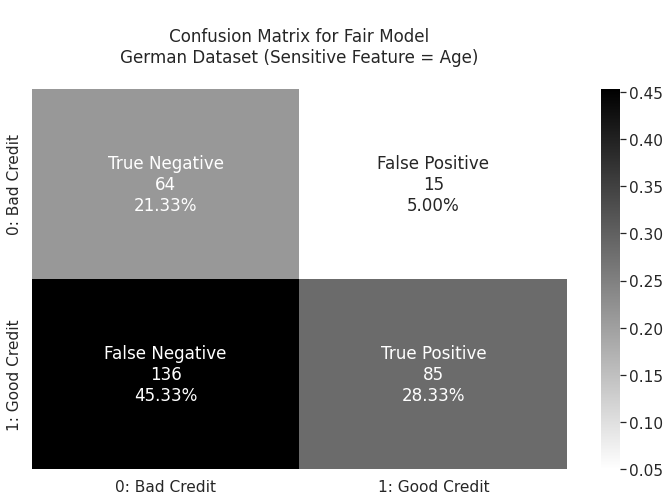


Epochs: 200
Accuracy: 49.67%
Fairness: 0.02487


In [ ]:
# MODEL (2) 
# TEST MOST FAIR MODEL FOR GERMAN DATASET (AGE) ON TEST DATA

model_g2 = EvaluateModel('age')

model_g2_data, test_pred_g2 = model_g2.fit(german_trn_a, 
                                           german_tst_a,
                                           lr=1e-5, 
                                           reg=1e-6,
                                           epochs=epochs)

PGG.plot_cfmatrix(model_g2_data, 
                  test_pred_g2, 
                  german_tst_a,
                  '1: Good Credit', 
                  '0: Bad Credit',
                  'Fair', 
                  'German Dataset (Sensitive Feature = Age)')

### <font color='#CD661D'>TASK 2: GERMAN</font>

In [ ]:
# EVALUATE HYPERPARAMETERS FOR REWEIGHTED GERMAN DATASET USING TRAINING DATA

mg2_rwt = EvaluateModel('age')
mg2_data = mg2_rwt.test_hyperparam(german_trn_a,
                                   learning_rates,
                                   reg_strength,
                                   epochs=epochs,
                                   reweight=True)

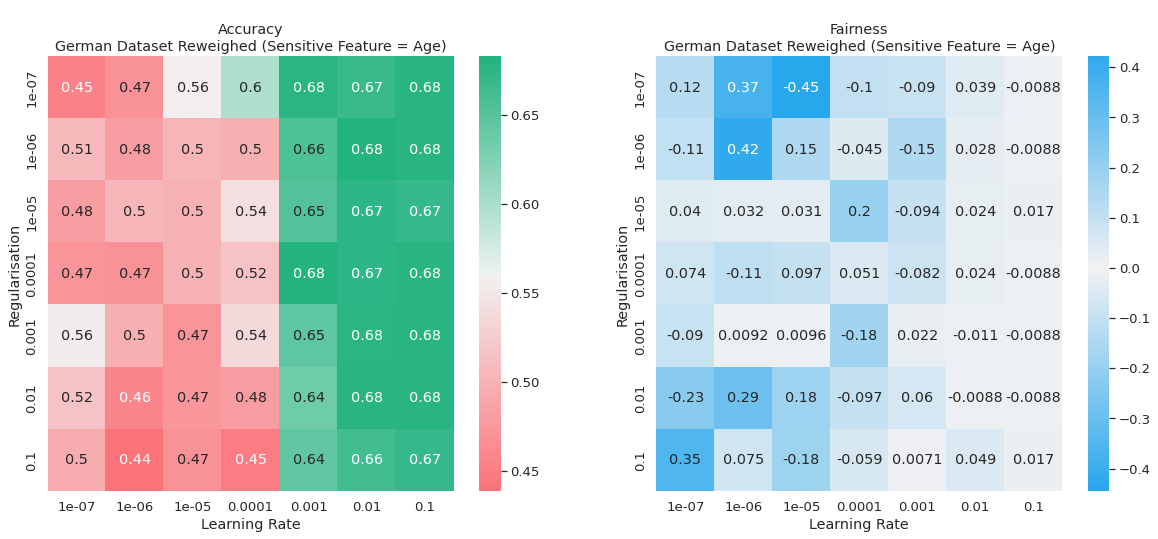

In [ ]:
PGG.plot_heatmap(mg2_data, 'German Dataset Reweighed (Sensitive Feature = Age)')

  0%|          | 299/100000 [00:00<00:40, 2483.98it/s]


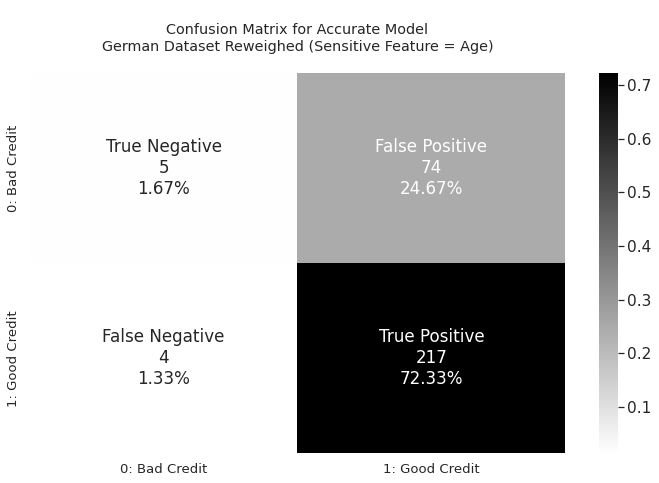


Epochs: 300
Accuracy: 74.00%
Fairness: 0.02235


In [ ]:
# MODEL (3) 
# TEST MOST ACCURATE MODEL WITH PREPROCESSED REWEIGHED TRAINING DATA ON TEST DATA

model_g3 = EvaluateModel('age')

model_g3_data, test_pred_g3 = model_g3.fit(german_trn_a, 
                                           german_tst_a,
                                           lr=1e-1, 
                                           reg=1e-2,
                                           epochs=epochs,
                                           reweight=True)

PGG.plot_cfmatrix(model_g3_data, 
                  test_pred_g3, 
                  german_tst_a, 
                  '1: Good Credit', 
                  '0: Bad Credit',
                  'Accurate', 
                  'German Dataset Reweighed (Sensitive Feature = Age)')

  0%|          | 299/100000 [00:00<00:41, 2390.58it/s]


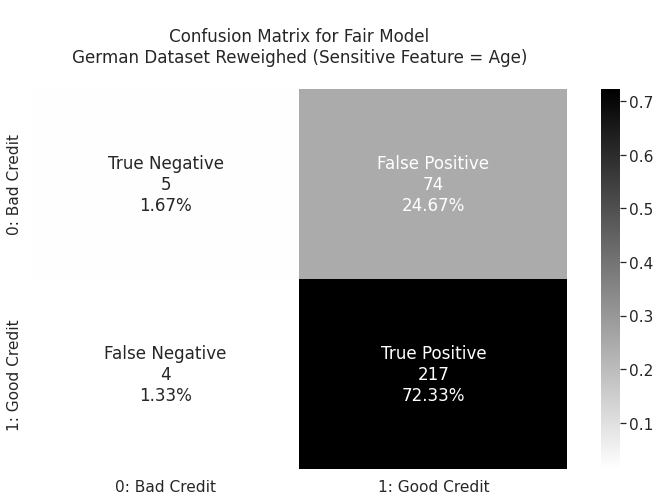


Epochs: 300
Accuracy: 74.00%
Fairness: 0.02235


In [ ]:
# MODEL (4) 
# MOST FAIR MODEL WITH PREPROCESSED REWEIGHED TRAINING DATA ON TEST DATA

model_g4 = EvaluateModel('age')

model_g4_data, test_pred_g4 = model_g4.fit(german_trn_a, 
                                           german_tst_a,
                                           lr=1e-1, 
                                           reg=1e-2,
                                           epochs=epochs,
                                           reweight=True)

PGG.plot_cfmatrix(model_g4_data, test_pred_g4, german_tst_a, 
                  '1: Good Credit', '0: Bad Credit',
                  'Fair', 
                  'German Dataset Reweighed (Sensitive Feature = Age)')

### <font color='#CD661D'>TASK 3: GERMAN</font>

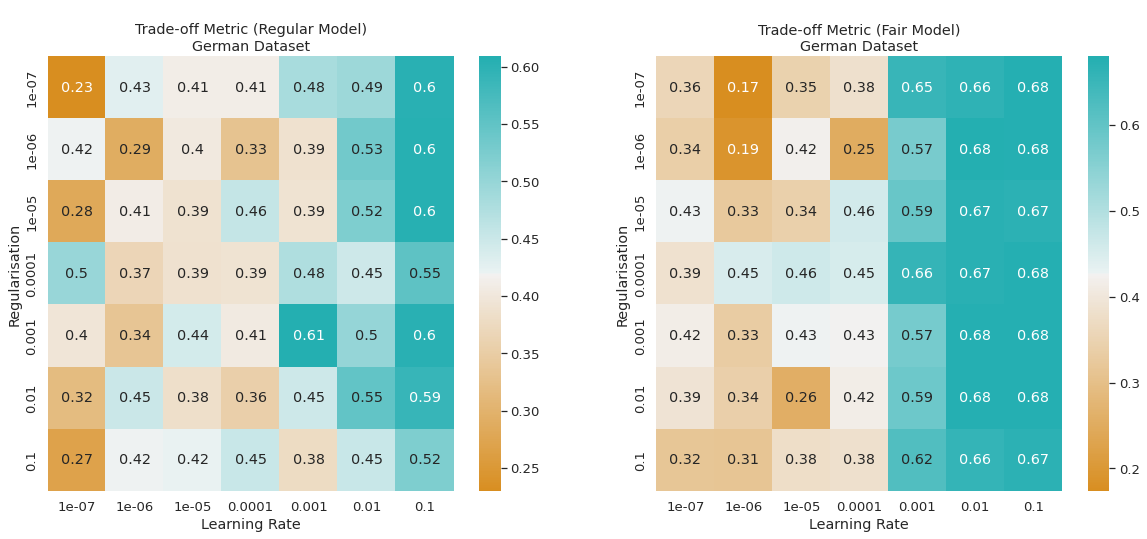

In [ ]:
# EVALUATE TRADE-OFF METRIC FOR ADULT DATASET 

PGG.tradeoff_heatmap(mg1_data, mg2_data, 'German Dataset')

  5%|▍         | 4799/100000 [00:01<00:35, 2664.16it/s]


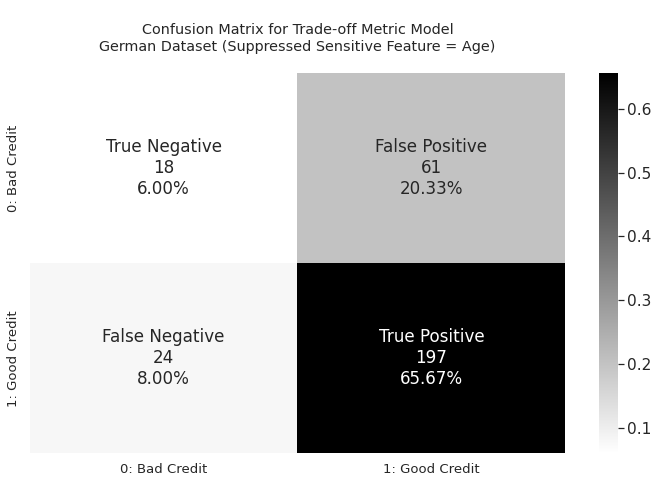


Epochs: 4800
Accuracy: 71.67%
Fairness: -0.3069


In [ ]:
# MODEL (5) 
# TEST BEST TRADE-OFF METRIC FOR STANDARD MODEL FOR GERMAN DATASET (AGE) ON TEST DATA

model_g5 = EvaluateModel('age')

model_g5_data, test_pred_g5 = model_g5.fit(german_trn_a, 
                                           german_tst_a,
                                           lr=1e-3, 
                                           reg=1e-3, 
                                           epochs=epochs)

PGG.plot_cfmatrix(model_g5_data, 
                  test_pred_g5, 
                  german_tst_a,
                  '1: Good Credit', 
                  '0: Bad Credit',
                  'Trade-off Metric',
                  'German Dataset (Suppressed Sensitive Feature = Age)')

  0%|          | 299/100000 [00:00<00:39, 2543.00it/s]


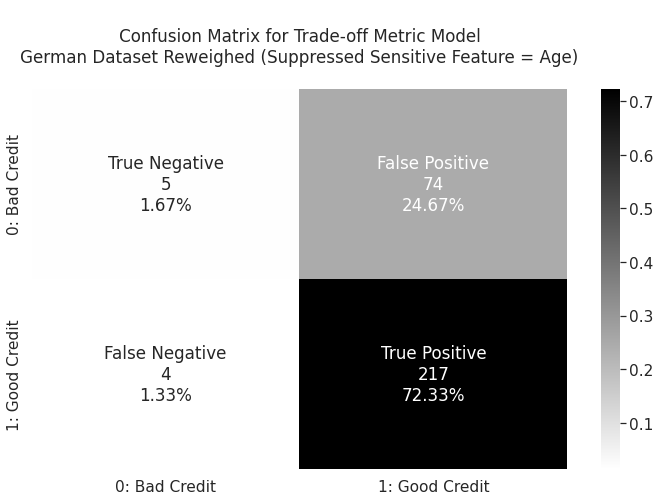


Epochs: 300
Accuracy: 74.00%
Fairness: 0.02235


In [ ]:
# MODEL (6) 
# TEST BEST TRADE-OFF METRIC FOR FAIR MODEL FOR GERMAN DATASET (SEX) ON TEST DATA

model_g6 = EvaluateModel('age')

model_g6_data, test_pred_g6 = model_g6.fit(german_trn_a, 
                                           german_tst_a,
                                           lr=1e-1, 
                                           reg=1e-2, 
                                           epochs=epochs,
                                           reweight=True)

PGG.plot_cfmatrix(model_g6_data, 
                  test_pred_g6, 
                  german_tst_a,
                  '1: Good Credit', 
                  '0: Bad Credit',
                  'Trade-off Metric',
                  'German Dataset Reweighed (Suppressed Sensitive Feature = Age)')

## <font color='#CD4F39'>**PART 5:** Suppressed Sensitive Feature(s) - Adult and German Datasets</font>

### <font color='#B22222'>Adult Dataset</font>

#### ONE SENSITIVE FEATURE SUPPRESSED

In [ ]:
# EVALUATE HYPERPARAMETERS FOR ADULT DATASET FOR STANDARD MODEL TRAINED WITH ONE 
# SENSITIVE FEATURE REMOVED FROM DATASET

ma_sens1 = EvaluateModel('sex')
ma_sens1_data = ma_sens1.test_hyperparam(adult_trn_s,
                                       learning_rates,
                                       reg_strength,
                                       epochs=epochs,
                                       suppress_sens=True,
                                       only_sens=True)

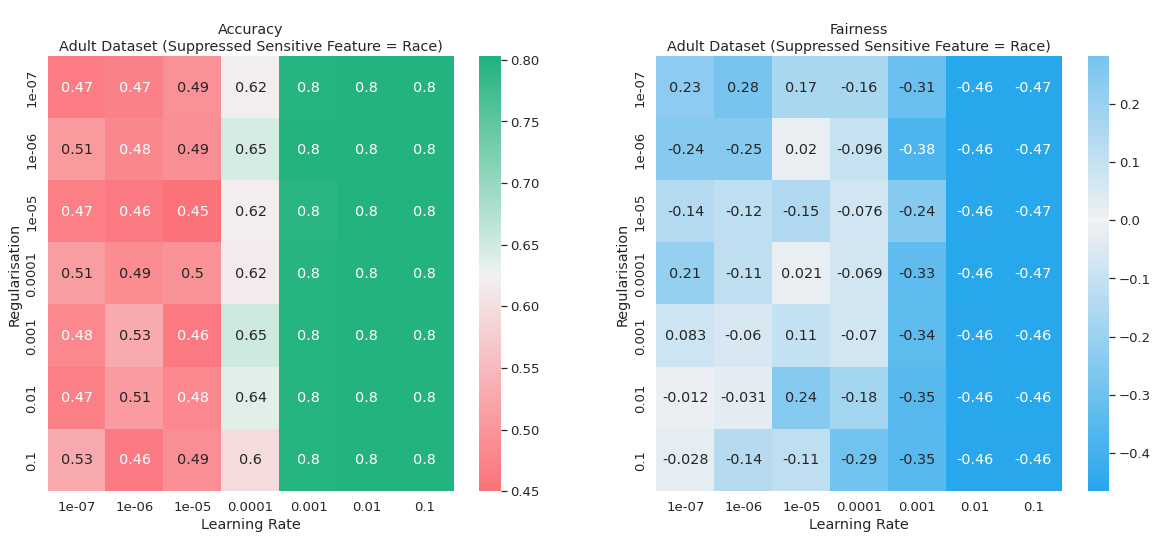

In [ ]:
# PLOT HYPERPARAMETER HEATMAPS FOR ADULT DATASET

PGA.plot_heatmap(ma_sens1_data, 'Adult Dataset (Suppressed Sensitive Feature = Race)')

  0%|          | 299/100000 [00:00<02:59, 554.37it/s]


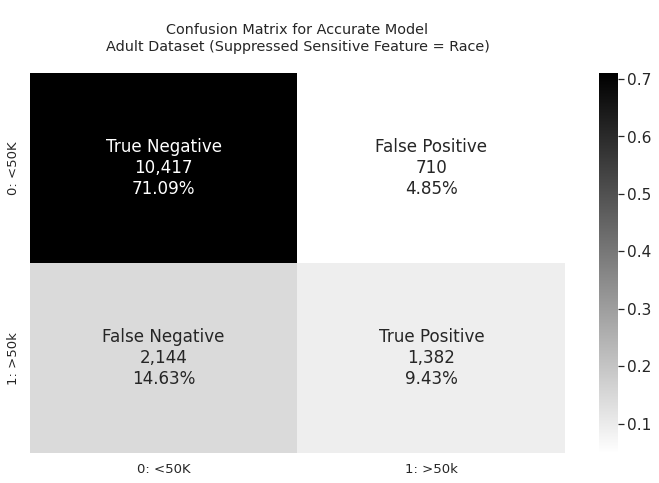


Epochs: 300
Accuracy: 80.52%
Fairness: -0.4613


In [ ]:
# MODEL (s1) 
# MOST ACCURATE MODEL FOR ADULT DATASET (SEX) WITH SENSITIVE FEATURE RACE REMOVED
model_s1 = EvaluateModel('sex')

model_s1_data, test_pred_s1 = model_s1.fit(adult_trn_s,
                                           adult_tst_s,
                                           lr=1e-1,
                                           reg=1e-1, 
                                           epochs=epochs,
                                           suppress_sens=True,
                                           only_sens=True)

PGA.plot_cfmatrix(model_s1_data, 
                  test_pred_s1, 
                  adult_tst_s,
                  '1: >50k', 
                  '0: <50K', 
                  'Accurate', 
                  'Adult Dataset (Suppressed Sensitive Feature = Race)')

  0%|          | 199/100000 [00:00<03:06, 535.11it/s]


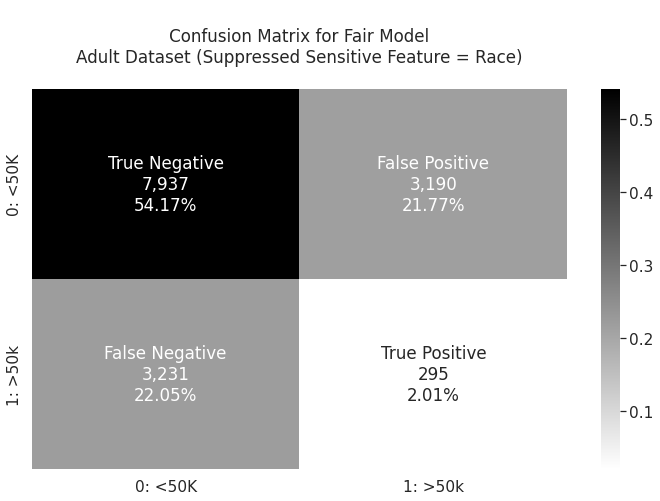


Epochs: 200
Accuracy: 56.18%
Fairness: 0.01478


In [ ]:
# MODEL (s2) 
# MOST FAIR MODEL FOR ADULT DATASET (SEX) WITH SENSITIVE FEATURE RACE REMOVED

model_s2 = EvaluateModel('sex')

model_s2_data, test_pred_s2 = model_s2.fit(adult_trn_s,
                                           adult_tst_s,
                                           lr=1e-7, 
                                           reg=1e-2, 
                                           epochs=epochs,
                                           suppress_sens=True,
                                           only_sens=True)

PGA.plot_cfmatrix(model_s2_data, 
                  test_pred_s2, 
                  adult_tst_s,
                  '1: >50k', 
                  '0: <50K', 
                  'Fair', 
                  'Adult Dataset (Suppressed Sensitive Feature = Race)')

#### BOTH SENSITIVE FEATURES SUPPRESSED

In [ ]:
# EVALUATE HYPERPARAMETERS FOR ADULT DATASET FOR STANDARD MODEL TRAINED WITH BOTH 
# SENSITIVE FEATURES REMOVED FROM DATASET

ma_sens2 = EvaluateModel('sex')
ma_sens2_data = ma_sens2.test_hyperparam(adult_trn_s,
                                       learning_rates,
                                       reg_strength,
                                       epochs=epochs,
                                       suppress_sens=True,
                                       only_sens=False)

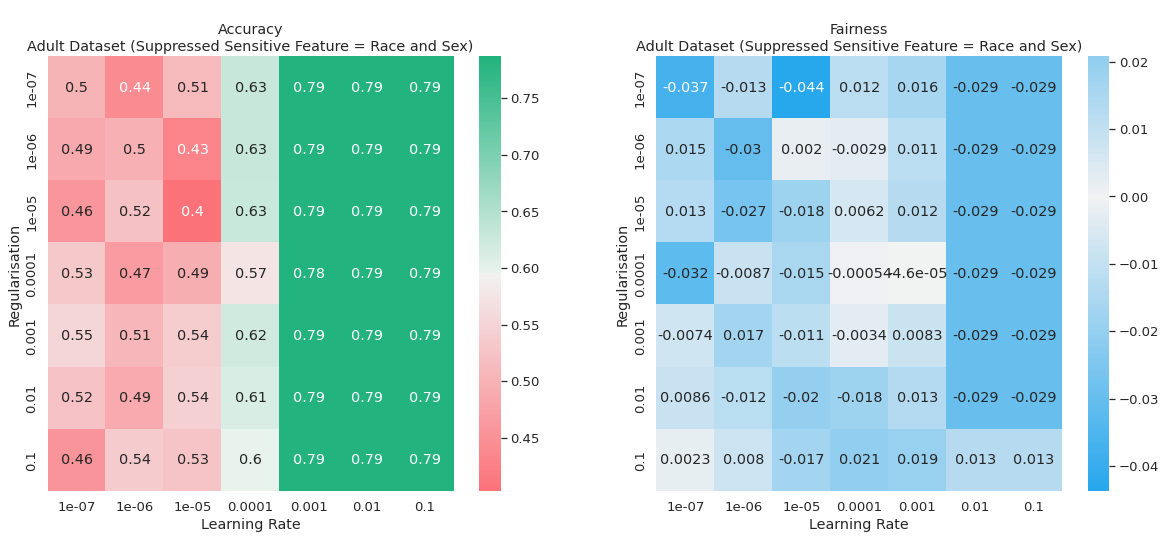

In [ ]:
# PLOT HYPERPARAMETER HEATMAPS FOR ADULT DATASET

PGA.plot_heatmap(ma_sens2_data, 'Adult Dataset (Suppressed Sensitive Feature = Race and Sex)')

  0%|          | 299/100000 [00:00<02:45, 603.59it/s]


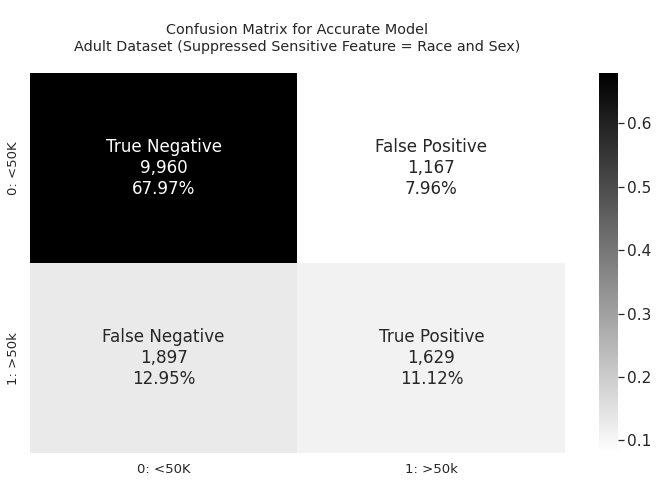


Epochs: 300
Accuracy: 79.09%
Fairness: 0.004756


In [ ]:
# MODEL (s3) 
# MOST ACCURATE MODEL FOR ADULT DATASET (SEX) WITH SENSITIVE FEATURES RACE AND SEX REMOVED

model7 = EvaluateModel('sex')

model7_data, test_pred7 = model7.fit(adult_trn_s, 
                                     adult_tst_s,
                                     lr=1e-1, 
                                     reg=1e-1, 
                                     epochs=epochs,
                                     suppress_sens=True,
                                     only_sens=False)

PGA.plot_cfmatrix(model7_data, test_pred7, adult_tst_s,
                  '1: >50k', '0: <50K', 
                  'Accurate', 'Adult Dataset (Suppressed Sensitive Feature = Race and Sex)')

  6%|▌         | 6199/100000 [00:10<02:33, 612.27it/s]


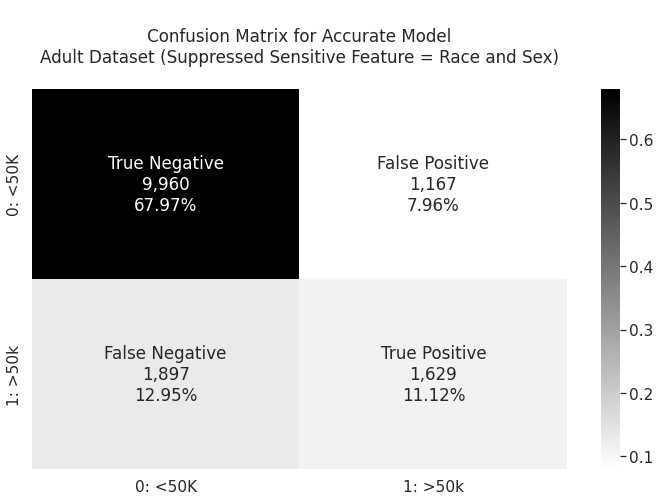


Epochs: 6200
Accuracy: 79.09%
Fairness: 0.004756


In [ ]:
# MODEL (s4) 
# MOST FAIR MODEL FOR ADULT DATASET (SEX) WITH SENSITIVE FEATURES RACE AND SEX REMOVED

model8 = EvaluateModel('sex')

model8_data, test_pred8 = model8.fit(adult_trn_s, 
                                     adult_tst_s,
                                     lr=1e-3, 
                                     reg=1e-4, 
                                     epochs=epochs,
                                     suppress_sens=True,
                                     only_sens=False)

PGA.plot_cfmatrix(model8_data, test_pred8, adult_tst_s,
                  '1: >50k', '0: <50K', 
                  'Accurate', 'Adult Dataset (Suppressed Sensitive Feature = Race and Sex)')

### <font color='#B22222'>German Dataset</font>

#### ONE SENSITIVE FEATURE SUPPRESSED

In [ ]:
# EVALUATE HYPERPARAMETERS FOR GERMAN DATASET FOR STANDARD MODEL TRAINED WITH ONE 
# SENSITIVE FEATURE REMOVED FROM DATASET

mg_sens1 = EvaluateModel('sex')
mg_sens1_data = mg_sens1.test_hyperparam(german_trn_s,
                                         learning_rates,
                                         reg_strength,
                                         epochs=epochs,
                                         suppress_sens=True,
                                         only_sens=True)

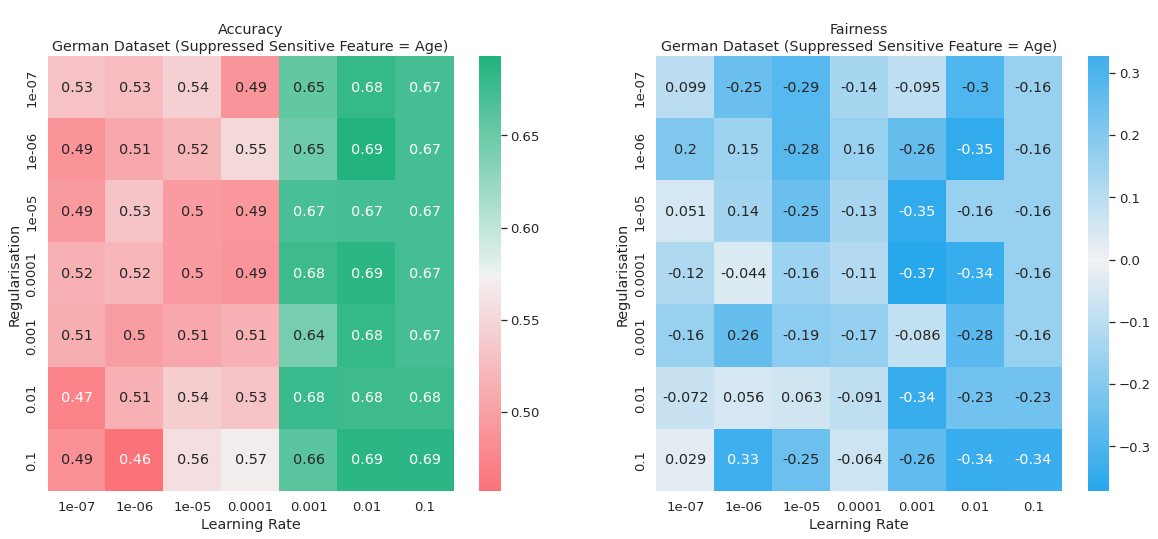

In [ ]:
# PLOT HYPERPARAMETER HEATMAPS FOR GERMAN DATASET

PGG.plot_heatmap(mg_sens1_data, 'German Dataset (Suppressed Sensitive Feature = Age)')

  0%|          | 299/100000 [00:00<00:44, 2246.68it/s]


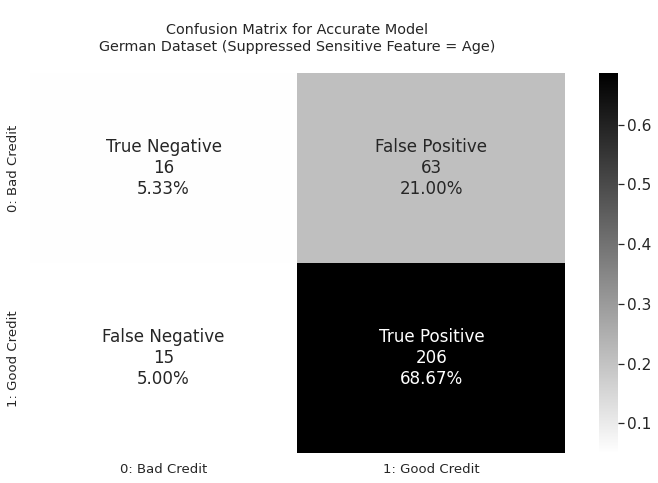


Epochs: 300
Accuracy: 74.00%
Fairness: -0.06318


In [ ]:
# MODEL (s1) 
# MOST ACCURATE MODEL FOR GERMAN DATASET (AGE) WITH SENSITIVE FEATURE AGE REMOVED

model_sg1 = EvaluateModel('age')

model_sg1_data, test_pred_sg1 = model_sg1.fit(german_trn_a, 
                                              german_tst_a,
                                              lr=1e-1, 
                                              reg=1e-1,
                                              epochs=epochs,
                                              suppress_sens=True,
                                              only_sens=True)

PGG.plot_cfmatrix(model_sg1_data, 
                  test_pred_sg1, 
                  german_tst_a, 
                  '1: Good Credit', 
                  '0: Bad Credit',
                  'Accurate', 
                  'German Dataset (Suppressed Sensitive Feature = Age)')

  0%|          | 199/100000 [00:00<00:39, 2519.83it/s]


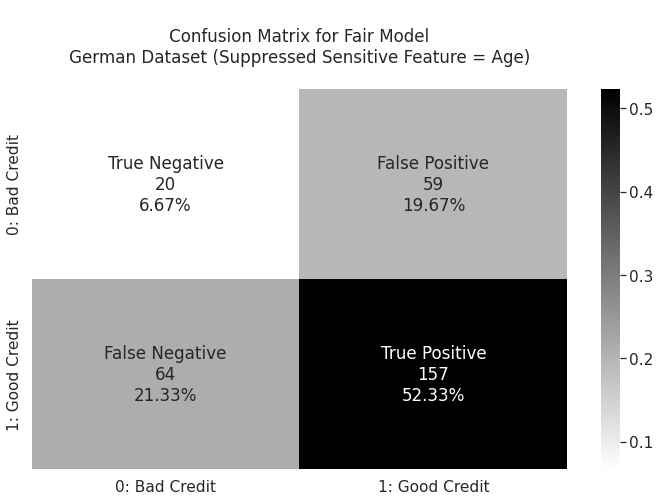


Epochs: 200
Accuracy: 59.00%
Fairness: -0.1422


In [ ]:
# MODEL (s2) 
# MOST FAIR MODEL FOR GERMAN DATASET (AGE) WITH SENSITIVE FEATURES AGE AND SEX REMOVED

model_sg2 = EvaluateModel('age')

model_sg2_data, test_pred_sg2 = model_sg2.fit(german_trn_a, 
                                              german_tst_a,
                                              lr=1e-7, 
                                              reg=1e-1,
                                              epochs=epochs,
                                              suppress_sens=True,
                                              only_sens=True)

PGG.plot_cfmatrix(model_sg2_data, 
                  test_pred_sg2, 
                  german_tst_a, 
                  '1: Good Credit', 
                  '0: Bad Credit',
                  'Fair', 
                  'German Dataset (Suppressed Sensitive Feature = Age)')

#### BOTH SENSITIVE FEATURES SUPPRESSED

In [ ]:
# EVALUATE HYPERPARAMETERS FOR GERMAN DATASET FOR STANDARD MODEL TRAINED WITH BOTH 
# SENSITIVE FEATURES REMOVED FROM DATASET

mg_sens2 = EvaluateModel('sex')
mg_sens2_data = mg_sens2.test_hyperparam(german_trn_s,
                                         learning_rates,
                                         reg_strength,
                                         epochs=epochs,
                                         suppress_sens=True,
                                         only_sens=False)

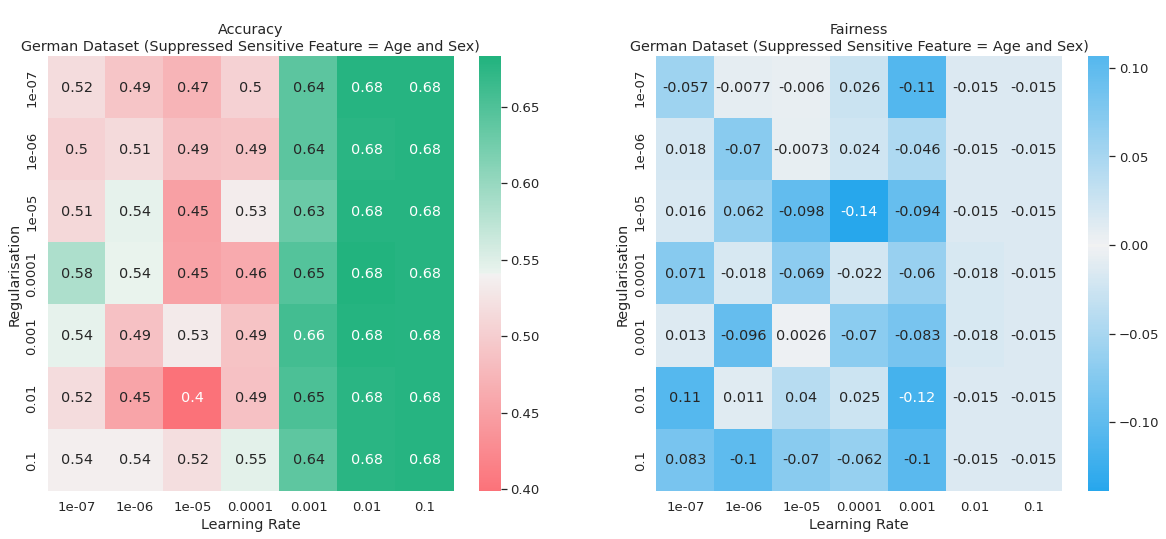

In [ ]:
# PLOT HYPERPARAMETER HEATMAPS FOR GERMAN DATASET

PGG.plot_heatmap(mg_sens2_data, 'German Dataset (Suppressed Sensitive Feature = Age and Sex)')

  0%|          | 299/100000 [00:00<00:39, 2512.76it/s]


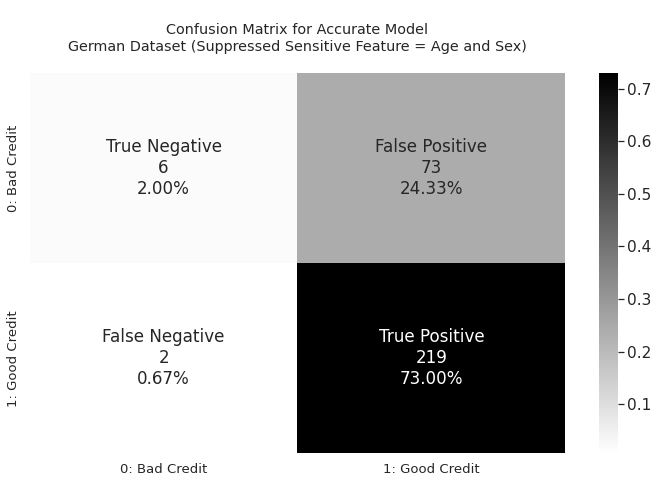


Epochs: 300
Accuracy: 75.00%
Fairness: 0.01117


In [ ]:
# MODEL (s3) 
# MOST ACCURATE MODEL FOR GERMAN DATASET (AGE) WITH SENSITIVE FEATURES AGE AND SEX REMOVED

model_sg3 = EvaluateModel('age')

model_sg3_data, test_pred_sg3 = model_sg3.fit(german_trn_a, 
                                              german_tst_a,
                                              lr=1e-1, 
                                              reg=1e-1,
                                              epochs=epochs,
                                              suppress_sens=True,
                                              only_sens=False)

PGG.plot_cfmatrix(model_sg3_data, 
                  test_pred_sg3, 
                  german_tst_a, 
                  '1: Good Credit', 
                  '0: Bad Credit',
                  'Accurate', 
                  'German Dataset (Suppressed Sensitive Feature = Age and Sex)')

  0%|          | 199/100000 [00:00<00:40, 2464.96it/s]


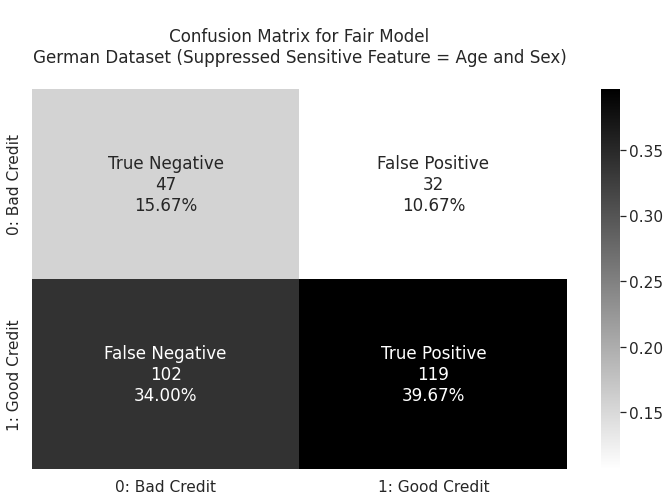


Epochs: 200
Accuracy: 55.33%
Fairness: -0.1357


In [ ]:
# MODEL (s4) 
# MOST FAIR MODEL FOR GERMAN DATASET (AGE) WITH SENSITIVE FEATURES AGE AND SEX REMOVED

model_sg4 = EvaluateModel('age')

model_sg4_data, test_pred_sg4 = model_sg4.fit(german_trn_a, 
                                              german_tst_a,
                                              lr=1e-5, 
                                              reg=1e-3,
                                              epochs=epochs,
                                              suppress_sens=True,
                                              only_sens=False)

PGG.plot_cfmatrix(model_sg4_data, 
                  test_pred_sg4, 
                  german_tst_a, 
                  '1: Good Credit', 
                  '0: Bad Credit',
                  'Fair', 
                  'German Dataset (Suppressed Sensitive Feature = Age and Sex)')